## Importações

In [1]:
from skmultilearn.adapt import MLkNN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from unicodedata import normalize
import joblib
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

import pandas as pd
import nltk
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
nltk.download('rslp')
nltk.download('stopwords')
plt.style.use('seaborn')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\syann\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Funções para leitura e pré-processamento do corpus


In [2]:
def open_dataset(dataset_name, dataset_type):
    if dataset_type == 'excel' or 'xlsx':
        df = pd.read_excel(str(dataset_name))
        return df
    elif dataset_type == 'csv':
        df = pd.read_excel(str(dataset_name))
        return df

def preprocess_text(text):
    """
    Realiza pré-processamento de texto em uma string.

    Args:
        text (str): O texto a ser pré-processado.

    Returns:
        str: O texto pré-processado.
    """
    text = remove_characters(text)
    text = remove_accents(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = untokenize(text)
    text = stemming(text)
    return text

def remove_characters(txt):
    """
    Remove caracteres especiais de uma string.

    Args:
        txt (str): A string de entrada.

    Returns:
        str: A string sem caracteres especiais.
    """
    sc = [k for k in txt.lower() if k not in string.punctuation]
    sc_ = ''.join(sc)
    return sc_

def remove_accents(txt):
    """
    Remove acentos de uma string.

    Args:
        txt (str): A string de entrada.

    Returns:
        str: A string sem acentos.
    """
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def tokenize(txt):
    """
    Tokeniza uma string em uma lista de tokens.

    Args:
        txt (str): A string de entrada.

    Returns:
        list: Uma lista de tokens.
    """
    return RegexpTokenizer('\w+').tokenize(txt)

def untokenize(txt):
    """
    Junta uma lista de tokens em uma única string.

    Args:
        txt (list): A lista de tokens.

    Returns:
        str: A string unida.
    """
    return (' ').join(i for i in txt)

def remove_stopwords(txt):
    """
    Remove stopwords de uma lista de tokens.

    Args:
        txt (list): A lista de tokens.

    Returns:
        list: A lista de tokens sem stopwords.
    """
    stopwords = nltk.corpus.stopwords.words('portuguese')
    return [w for w in txt if w.lower() not in stopwords]

def stemming(txt):
    """
    Realiza stemming em uma string.

    Args:
        txt (str): A string de entrada.

    Returns:
        str: A string após aplicação de stemming.
    """
    stemmer = nltk.stem.RSLPStemmer()
    return ' '.join([stemmer.stem(i) for i in txt.split()])

def vectorizer(X, vec_type):
    if vec_type == 'countvectorizer':
        CountVec = CountVectorizer()
        numeric_matrix = CountVec.fit_transform(X)
        return numeric_matrix

    elif vec_type == 'tfidf-vectorizer' or 'tfidf':
        Tfidf = TfidfVectorizer()
        numeric_matrix = Tfidf.fit_transform(X)
        return numeric_matrix

### Leitura do Corpus

In [3]:
df = open_dataset('tweetEmotionsPTBR.xlsx', 'xlsx')

([<matplotlib.patches.Wedge at 0x20c99a8e590>,
 [Text(1.0780790049241498, 0.218507801100453, 'alegria'),
  Text(0.9088407142183793, 0.6196842390919962, 'decepção'),
  Text(0.5976619954549425, 0.9234717858109236, 'confianca'),
  Text(0.19414395095271067, 1.0827317887216907, 'submissão'),
  Text(-0.2406331914839353, 1.0733571945798175, 'raiva'),
  Text(-0.6404623167916762, 0.8943198649084335, 'antecipacao'),
  Text(-0.9382813797667755, 0.5741324345331451, 'otimismo'),
  Text(-1.087539180555732, 0.1651015770856445, 'agressividade'),
  Text(-1.0669328903664175, -0.26768303542503846, 'medo'),
  Text(-0.8946371691710788, -0.6400190118563344, 'intimidação'),
  Text(-0.6008621107181524, -0.9213928173712485, 'remorso'),
  Text(-0.22091158863699617, -1.0775890079273631, 'surpresa'),
  Text(0.19360733626775753, -1.0828278715212791, 'nojo'),
  Text(0.5992629492364503, -0.9224336928324073, 'tristeza'),
  Text(0.911290467263821, -0.6160760377372966, 'desprezo'),
  Text(1.078563632189922, -0.21610296

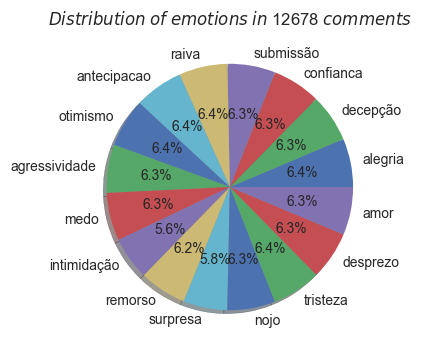

In [4]:
emotions = Counter(df.sentimento)
plt.figure(figsize=(9, 4))
plt.title(f'$Distribution $ $of$ $emotions$ $in$ {len(list(df.sentimento))} $comments$')
plt.pie(x=emotions.values(), labels=emotions.keys(),
        shadow=True, autopct='%1.1f%%')

### Pré-Processamento

In [5]:
descartar = ['UserTags', 'replys', 'reTweets', 'likes', 'sentimento']

for coluna in descartar:
    if coluna in df.columns:
        df = df.drop(coluna, axis=1)

In [6]:
df['texto'] = df['texto'].apply(preprocess_text)

df = df[df['texto'] != '']
df = df.drop_duplicates()

## Leitura  e pré- processamento do Corpus Teste

In [7]:
df_teste = open_dataset('FrasesChatgpt.xlsx', 'xlsx')

In [8]:
df_teste = df_teste.drop('sentimento', axis=1)

df_teste['texto'] = df_teste['texto'].apply(preprocess_text)
df_teste = df_teste[df_teste['texto'] != '']
df_teste = df_teste.drop_duplicates()

## Treinamento

### Definição das variáveis de treino e teste

In [9]:
X_train = df["texto"]
y_train = df.drop('texto', axis=1)

X_test = df_teste["texto"]
y_test = df_teste.drop('texto', axis=1)

# inicializando TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2500, max_df=0.9)
vectorizer.fit(X_train)
vectorizer.fit(X_test)

# transforming the data
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Treino da classificação multiLabel

In [10]:
# Defina o pipeline com o classificador MultiOutputClassifier
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(LinearSVC(random_state=0)))
])

# Defina os parâmetros que você deseja ajustar
parameters = {
    'clf__estimator__C': [100],  # Teste diferentes valores para o parâmetro de regularização C
    'clf__estimator__max_iter': [1000],  # Teste diferentes valores para o número máximo de iterações
    'clf__estimator__penalty': ['l2'],  # Teste diferentes penalidades (regularização l1 ou l2)
    'clf__estimator__tol': [1e-3],  # Teste diferentes valores de tolerância
    'clf__estimator__verbose': [0]  # Teste diferentes níveis de detalhe das mensagens de registro
}

# Inicialize o GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Ajuste o GridSearchCV aos dados
grid_search.fit(X_train_tfidf, y_train)

# Exiba os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

Melhores parâmetros encontrados:
{'clf__estimator__C': 100, 'clf__estimator__max_iter': 1000, 'clf__estimator__penalty': 'l2', 'clf__estimator__tol': 0.001, 'clf__estimator__verbose': 0}


#### Salvando e carregando o modelo treinado

In [11]:
modelo_path = 'modeloGridSearch.pkl'

# Salvando o modelo usando joblib
joblib.dump(grid_search, modelo_path)

# Carregando o modelo salvo
clf_carregado = joblib.load(modelo_path)

## Teste

In [12]:
prediction = grid_search.predict(X_test_tfidf)
prediction

colunas = ['alegria', 'tristeza', 'raiva', 'medo', 'nojo', 'surpresa', 'confianca', 'antecipacao']

nomes_colunas_predicao = [colunas[i] for i in range(prediction.shape[1])]

for i, predicao_em_linha in enumerate(prediction):
    colunas_com_valor_1 = [nomes_colunas_predicao[j] for j, valor_predito in enumerate(predicao_em_linha) if valor_predito == 1]
    if colunas_com_valor_1:
        print(f"{', '.join(colunas_com_valor_1)}")
    else:
        print("Nenhuma emoção presente.")

alegria
alegria, antecipacao
alegria, confianca
alegria, confianca
alegria
raiva
alegria
alegria, medo, antecipacao
alegria
alegria, confianca
Nenhuma emoção presente.
alegria
alegria, antecipacao
alegria, antecipacao
alegria, antecipacao
alegria, antecipacao
alegria
alegria
tristeza
alegria
alegria, antecipacao
medo, confianca
alegria
alegria, antecipacao
medo, confianca
alegria, medo
alegria
alegria
alegria
alegria, antecipacao
medo, surpresa
medo, surpresa
medo, surpresa
medo, surpresa
medo, surpresa
Nenhuma emoção presente.
medo, surpresa
medo, surpresa
medo, surpresa
nojo
tristeza, surpresa
tristeza, surpresa
tristeza, surpresa
tristeza, surpresa
confianca
surpresa
nojo
Nenhuma emoção presente.
surpresa
surpresa
tristeza, nojo
tristeza, nojo
tristeza, nojo
tristeza, nojo
tristeza, nojo
tristeza, nojo
tristeza, nojo
tristeza, nojo
Nenhuma emoção presente.
tristeza, nojo
raiva, nojo
raiva, nojo
raiva, nojo
raiva, nojo
raiva, nojo
Nenhuma emoção presente.
nojo
raiva, nojo
nojo
raiva,

## Resultados

### Métricas

In [13]:
print('Hamming Loss: ', hamming_loss(y_test, prediction))
print('Acurácia: ', accuracy_score(y_test, prediction, ))
print('Precisão: ', precision_score(y_test, prediction, average='weighted'))
print('Recall: ', recall_score(y_test, prediction, average='weighted'))
print('Métrica F1: ', f1_score(y_test, prediction, average='weighted'))

Hamming Loss:  0.1125
Acurácia:  0.5625
Precisão:  0.8546208944793853
Recall:  0.6729559748427673
Métrica F1:  0.7320189483545988


### Relatório de classificação global

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Realizar a previsão no conjunto de dados não vistos
prediction_dadosNvistos = grid_search.predict(X_test_tfidf)

# Converter as previsões e rótulos verdadeiros para DataFrames para facilitar o cálculo de métricas
df_true_labels = y_test.reset_index(drop=True)

# Calcular métricas globais
accuracy = accuracy_score(df_true_labels, prediction_dadosNvistos)
precision_macro = precision_score(df_true_labels, prediction_dadosNvistos, average='macro')
recall_macro = recall_score(df_true_labels, prediction_dadosNvistos, average='macro')
f1_macro = f1_score(df_true_labels, prediction_dadosNvistos, average='macro')

print(f"Métricas Globais:")
print(f"Acurária: {accuracy:.4f}")
print(f"Precisão (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")

# Relatório de classificação global
print("\nRelatório de Classificação:")
print(classification_report(df_true_labels, prediction_dadosNvistos))

Métricas Globais:
Acurária: 0.5625
Precisão (Macro): 0.8536
Recall (Macro): 0.6724
F1 Score (Macro): 0.7314

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        20
           1       0.87      0.65      0.74        20
           2       0.94      0.85      0.89        20
           3       0.92      0.55      0.69        20
           4       0.90      0.90      0.90        20
           5       1.00      0.75      0.86        20
           6       0.83      0.25      0.38        20
           7       0.69      0.58      0.63        19

   micro avg       0.84      0.67      0.75       159
   macro avg       0.85      0.67      0.73       159
weighted avg       0.85      0.67      0.73       159
 samples avg       0.76      0.68      0.70       159



### Relatório de classificação por emoção

In [15]:
# Realizar a previsão no conjunto de dados não vistos
prediction_dadosNvistos = grid_search.predict(X_test_tfidf)

# Converter as previsões e rótulos verdadeiros para DataFrames para facilitar o cálculo de métricas
df_prediction = pd.DataFrame(prediction_dadosNvistos, columns=nomes_colunas_predicao)
df_true_labels = y_test.reset_index(drop=True)

# Calcular métricas para cada emoção
for coluna in nomes_colunas_predicao:
    accuracy = accuracy_score(df_true_labels[coluna], df_prediction[coluna])
    precision = precision_score(df_true_labels[coluna], df_prediction[coluna])
    recall = recall_score(df_true_labels[coluna], df_prediction[coluna])
    f1 = f1_score(df_true_labels[coluna], df_prediction[coluna])

    print(f"Métricas para a emoção '{coluna}':")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")

# Relatório de classificação para todas as emoções
print("Relatório de Classificação:")
print(classification_report(df_true_labels, df_prediction, target_names=nomes_colunas_predicao))

Métricas para a emoção 'alegria':
Acurácia: 0.8625
Precisão: 0.6800
Recall: 0.8500
F1 Score: 0.7556


Métricas para a emoção 'tristeza':
Acurácia: 0.8875
Precisão: 0.8667
Recall: 0.6500
F1 Score: 0.7429


Métricas para a emoção 'raiva':
Acurácia: 0.9500
Precisão: 0.9444
Recall: 0.8500
F1 Score: 0.8947


Métricas para a emoção 'medo':
Acurácia: 0.8750
Precisão: 0.9167
Recall: 0.5500
F1 Score: 0.6875


Métricas para a emoção 'nojo':
Acurácia: 0.9500
Precisão: 0.9000
Recall: 0.9000
F1 Score: 0.9000


Métricas para a emoção 'surpresa':
Acurácia: 0.9375
Precisão: 1.0000
Recall: 0.7500
F1 Score: 0.8571


Métricas para a emoção 'confianca':
Acurácia: 0.8000
Precisão: 0.8333
Recall: 0.2500
F1 Score: 0.3846


Métricas para a emoção 'antecipacao':
Acurácia: 0.8375
Precisão: 0.6875
Recall: 0.5789
F1 Score: 0.6286


Relatório de Classificação:
              precision    recall  f1-score   support

     alegria       0.68      0.85      0.76        20
    tristeza       0.87      0.65      0.74    